<table style="border:none; border-collapse:collapse; cellspacing:0; cellpadding:0">
    <tr>
        <td width=30% style="border:none">
            <img src="logo_datascientest.png" width="100%"/>
        </td>
        <td style="border:none">
            <center>
                <h1>DS project: Customer satisfaction</h1>
                <h2>Data exploration</h2>
            </center>
        </td>
    </tr>
</table>

<hr>

**Date** : 2023

**Author** : Elie MAZE, Luc Thomas

**Goal** : Data exploration, analysis

In [31]:
import _mypath
import os
import pandas as pd
import re
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
nltk.data.path.append("/data/DATALAB_PAU/18_HPC/nltk_data")

from nltk.corpus import stopwords

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from data.processing import findCAPSLOCK, find_chain_CAPSLOCK, find_exclamation, find_chain_exclamation, find_interogation
from data.processing import  find_chain_interogation, find_etc

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data loading

In [2]:
infile = os.path.join("../input/data/cleaned_merged_dataset.csv")
df = pd.read_csv(infile, sep=",", encoding="utf-8", engine="python")
print("data shape:", df.shape, end="\n\n")

df.head()

data shape: (105568, 8)



,Commentaire,star,date,client,reponse,source,company,langage
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr


# Analysis

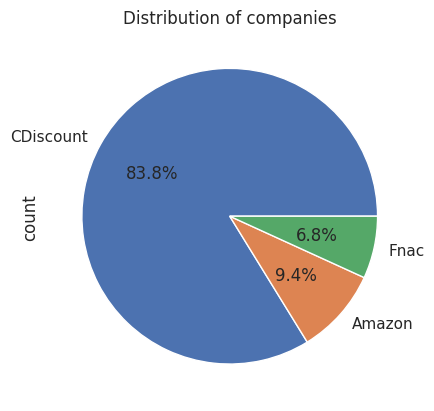

In [3]:
sns.set()
df["company"].value_counts().plot.pie(autopct="%.1f%%")
plt.title("Distribution of companies")
plt.show()

In [4]:
df.star.value_counts().sort_index(ascending=False)

star
5    53033
4    18427
3     6360
2     3607
1    24141
Name: count, dtype: int64

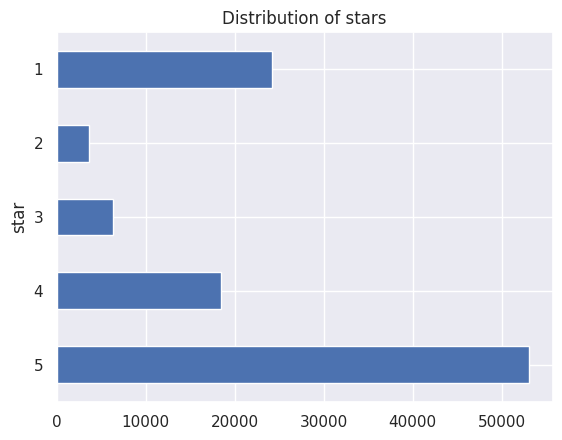

In [5]:
df.star.value_counts().sort_index(ascending=False).plot.barh()
plt.title("Distribution of stars")
plt.show()

In [6]:
df.source.value_counts()

source
TrustPilot    105568
Name: count, dtype: int64

## Reviews

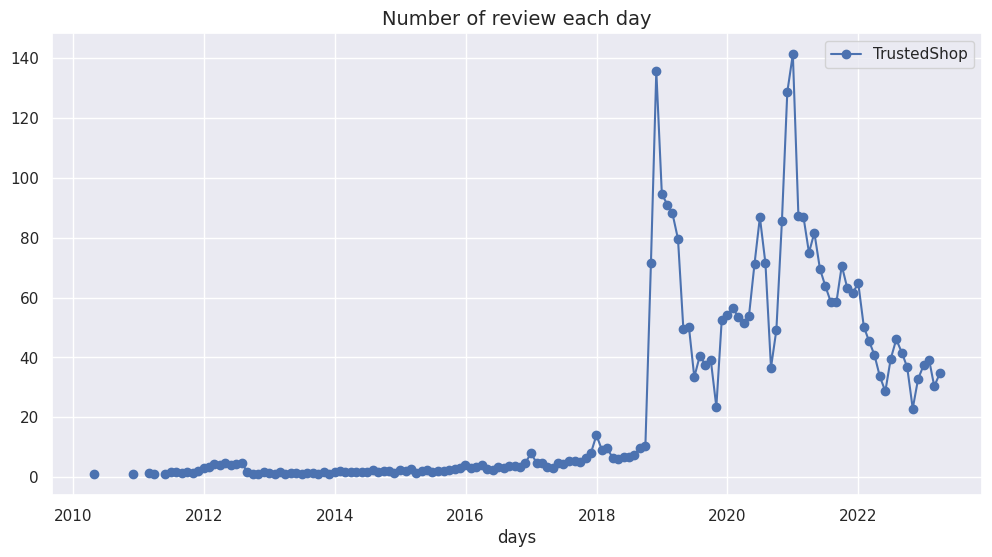

In [7]:
plt.figure(figsize=(12,6))

df.date = pd.to_datetime(df.date, utc=True)
values = df['date'].value_counts().sort_index().resample('M').mean()
plt.title('Number of review each day', fontsize=14)
plt.plot_date(values.index.values, values.values, linestyle='-', label='TrustedShop');
plt.xlabel("days")
plt.legend()
plt.show()

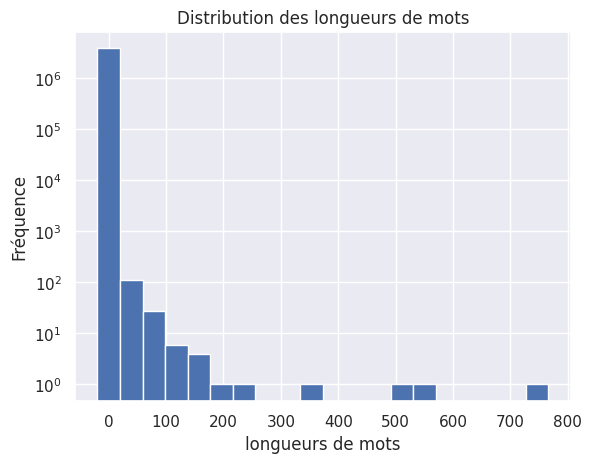

In [8]:
word_lengths = [len(word) for words in df["Commentaire"].str.split(" ").tolist() for word in words]

plt.hist(word_lengths, bins=20, align='left')

# Configuration de l'affichage
plt.yscale('log')
plt.xlabel('longueurs de mots')
plt.ylabel('Fréquence')
plt.title('Distribution des longueurs de mots')

# Affichage du graphique
plt.show()

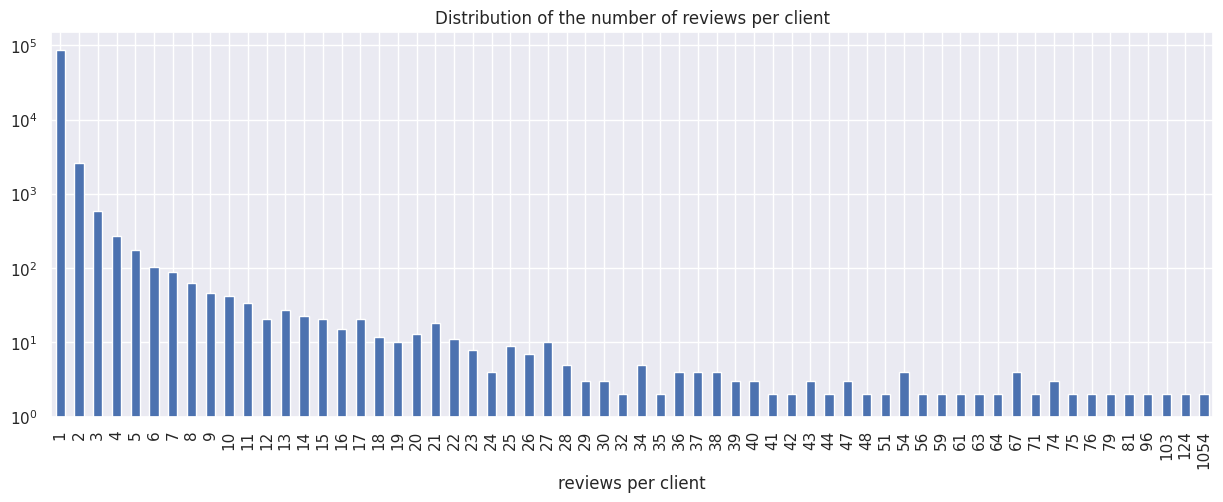

In [9]:
grouped_df = df.groupby('client').agg({'star': ['mean', 'count']})
grouped_df.columns = ['mean_star', 'star_count']

values = grouped_df["star_count"].value_counts().sort_index(ascending=True)

sns.set()
fig = plt.figure(figsize=(15,5))
values.plot.bar(log=True)
plt.xlabel("reviews per client")
plt.title("Distribution of the number of reviews per client")
plt.show()

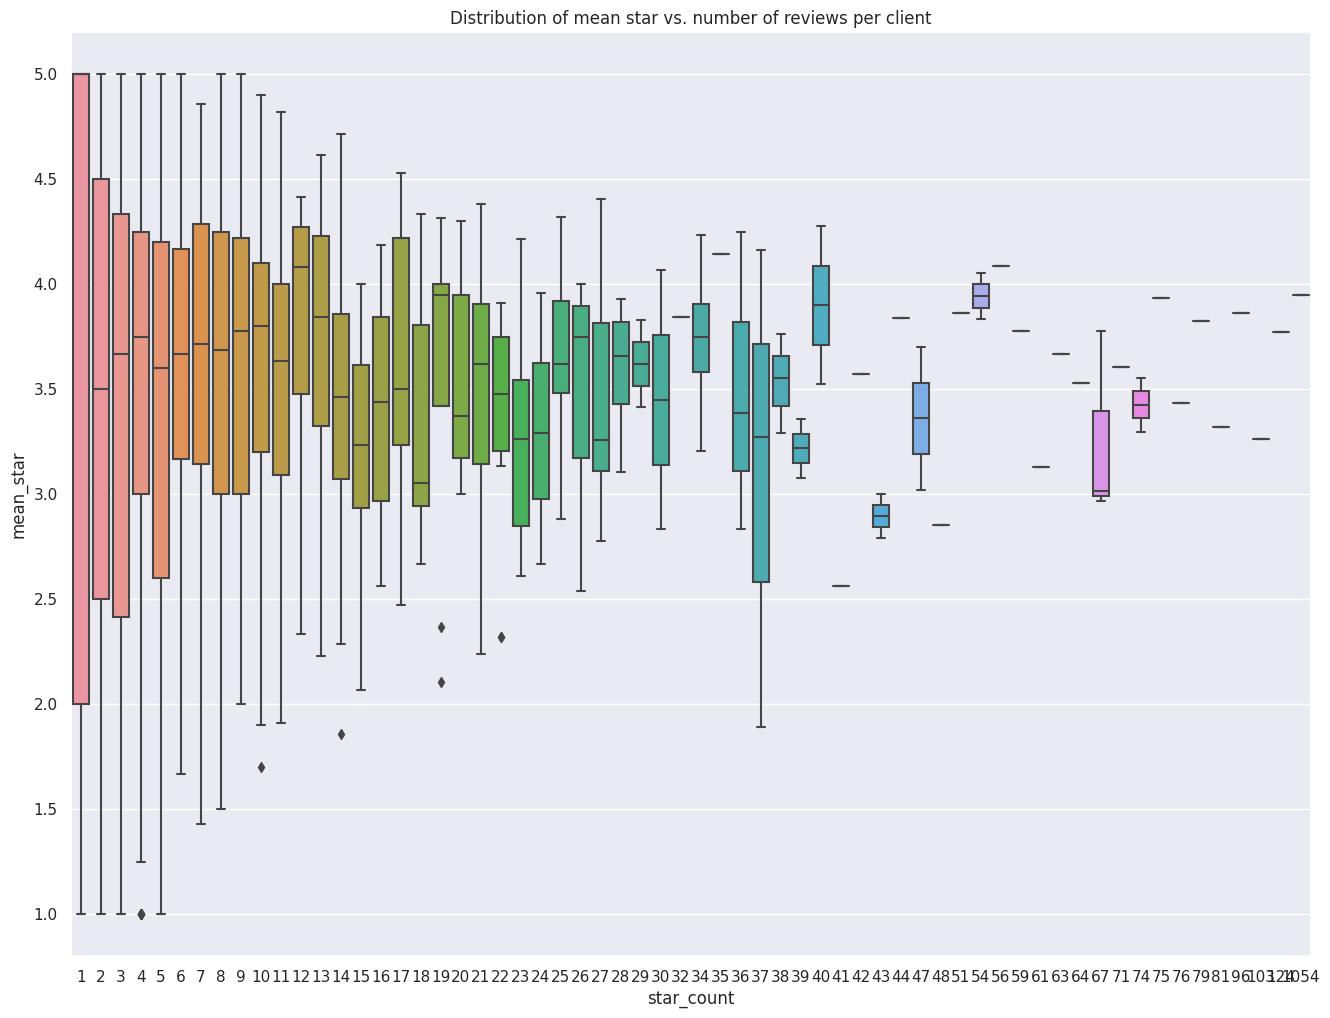

In [10]:
fig, ax = plt.subplots(figsize=[16,12])
sns.boxplot(x="star_count", y="mean_star", data=grouped_df, ax=ax)
plt.title("Distribution of mean star vs. number of reviews per client")
plt.show()

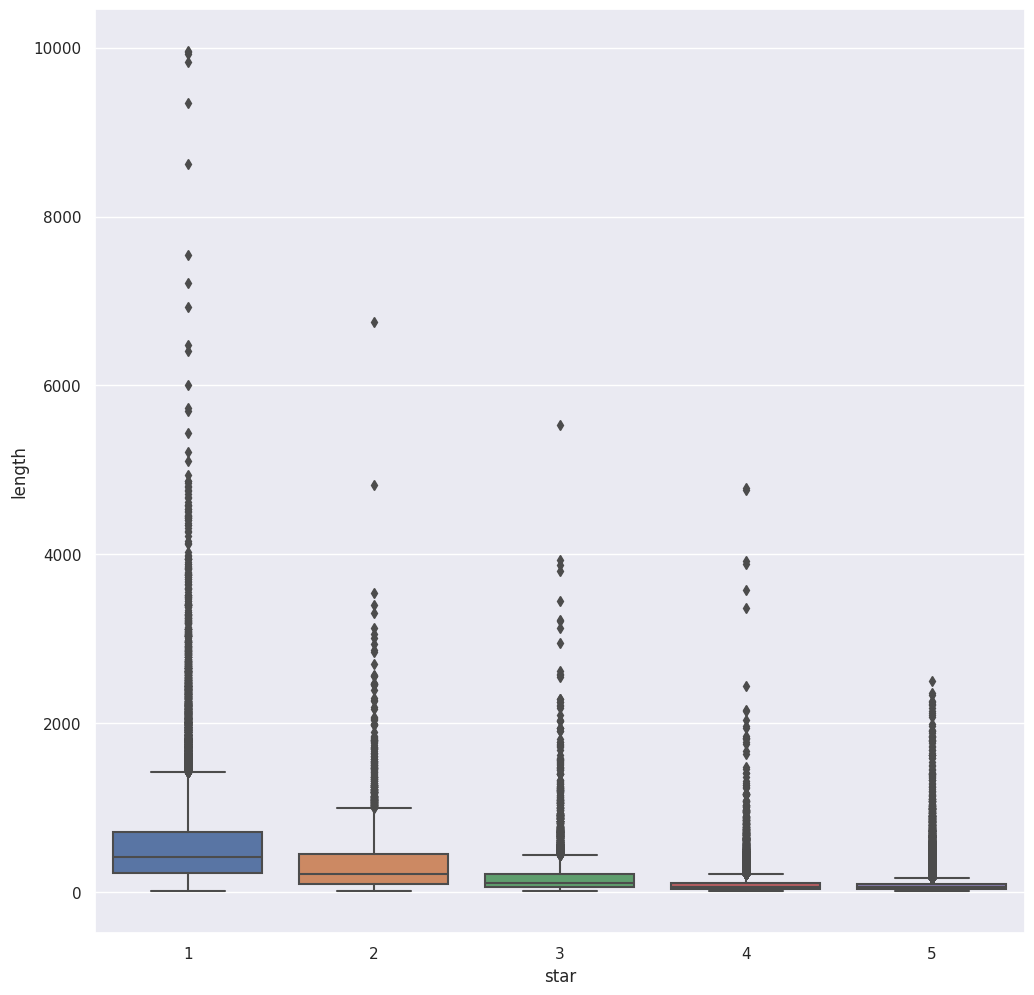

In [11]:
df['length'] = df['Commentaire'].str.len()

fig, ax = plt.subplots(figsize=[12,12])
sns.boxplot(x="star", y="length", data=df, ax=ax)
plt.show()

In [12]:
df['capslock'] = df.Commentaire.apply(lambda x: findCAPSLOCK(str(x)))
df['chain_capslock'] = df.Commentaire.apply(lambda x: find_chain_CAPSLOCK(str(x)))
df['exclamation'] = df.Commentaire.apply(lambda x: find_exclamation(str(x)))
df['chain_exclamation'] = df.Commentaire.apply(lambda x: find_chain_exclamation(str(x)))
df['interogation'] = df.Commentaire.apply(lambda x: find_interogation(str(x)))
df['chain_interogation'] = df.Commentaire.apply(lambda x: find_chain_interogation(str(x)))

df['etc'] = df.Commentaire.apply(lambda x: find_etc(str(x)))

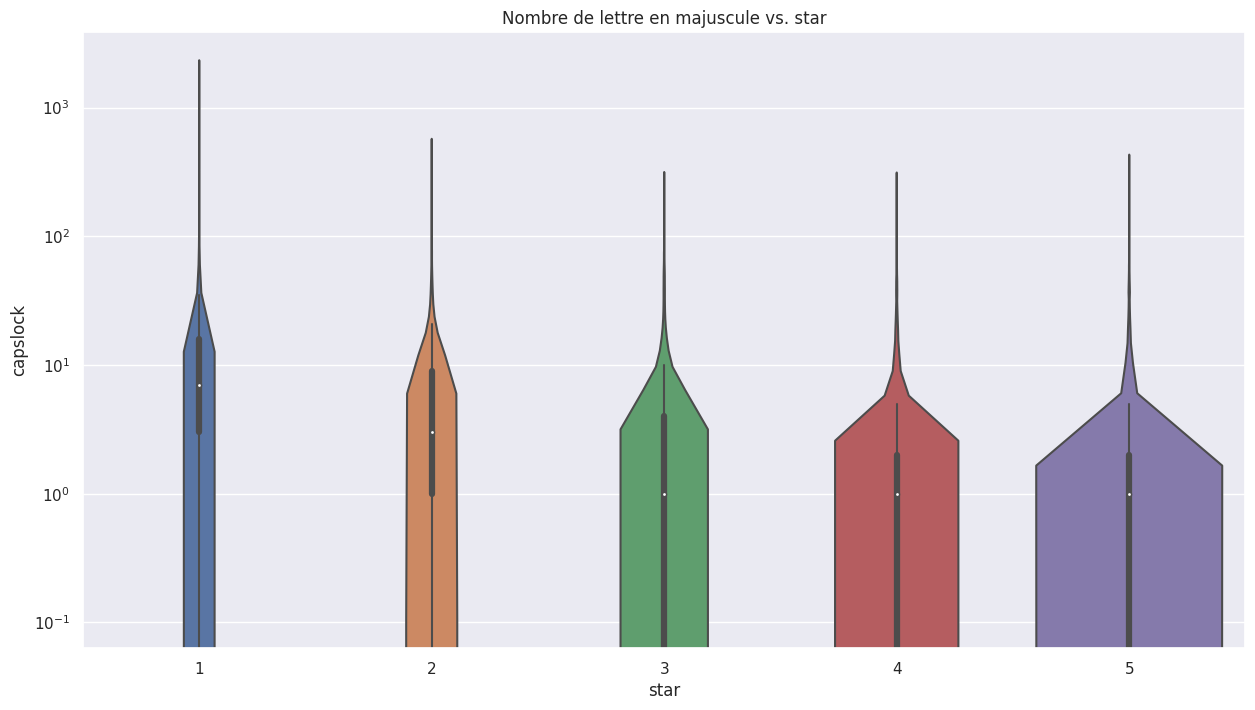

In [13]:
fig, ax = plt.subplots(figsize=[15,8])
sns.violinplot(x="star", y="capslock", data=df, ax=ax)
plt.yscale('log')
plt.title("Nombre de lettre en majuscule vs. star")
plt.show()

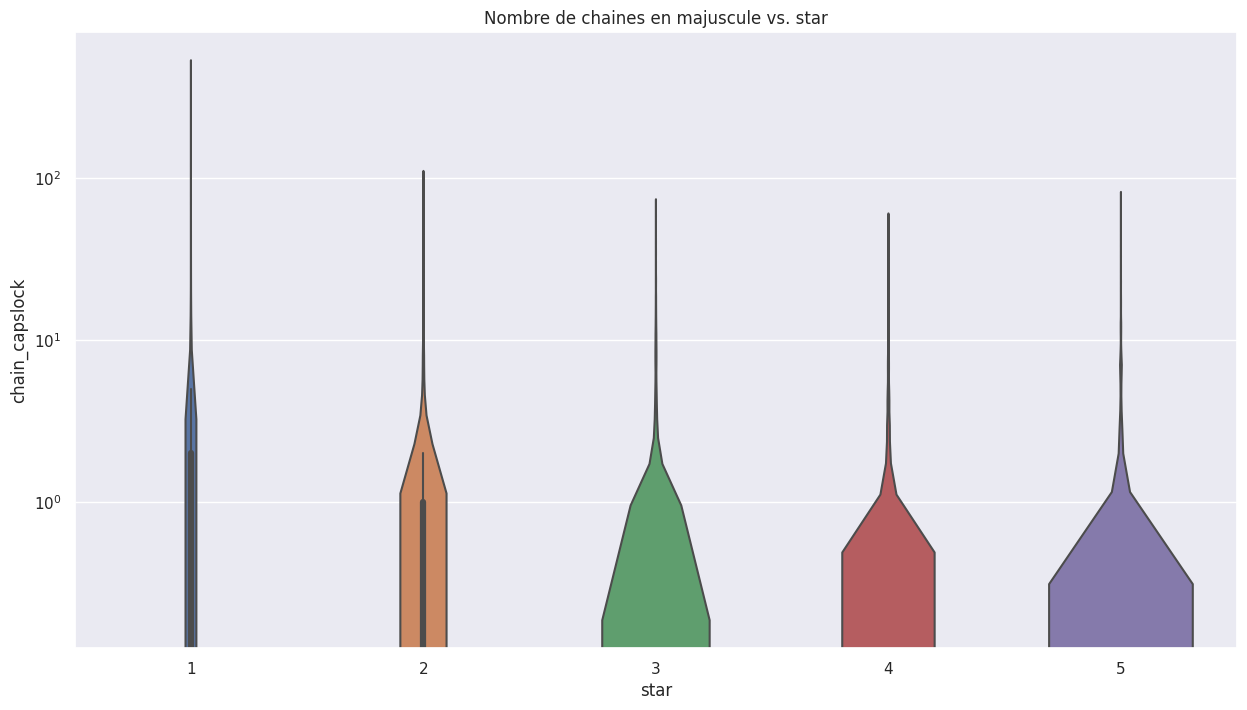

In [14]:
fig, ax = plt.subplots(figsize=[15,8])
sns.violinplot(x="star", y="chain_capslock", data=df, ax=ax)
plt.yscale('log')
plt.title("Nombre de chaines en majuscule vs. star")
plt.show()

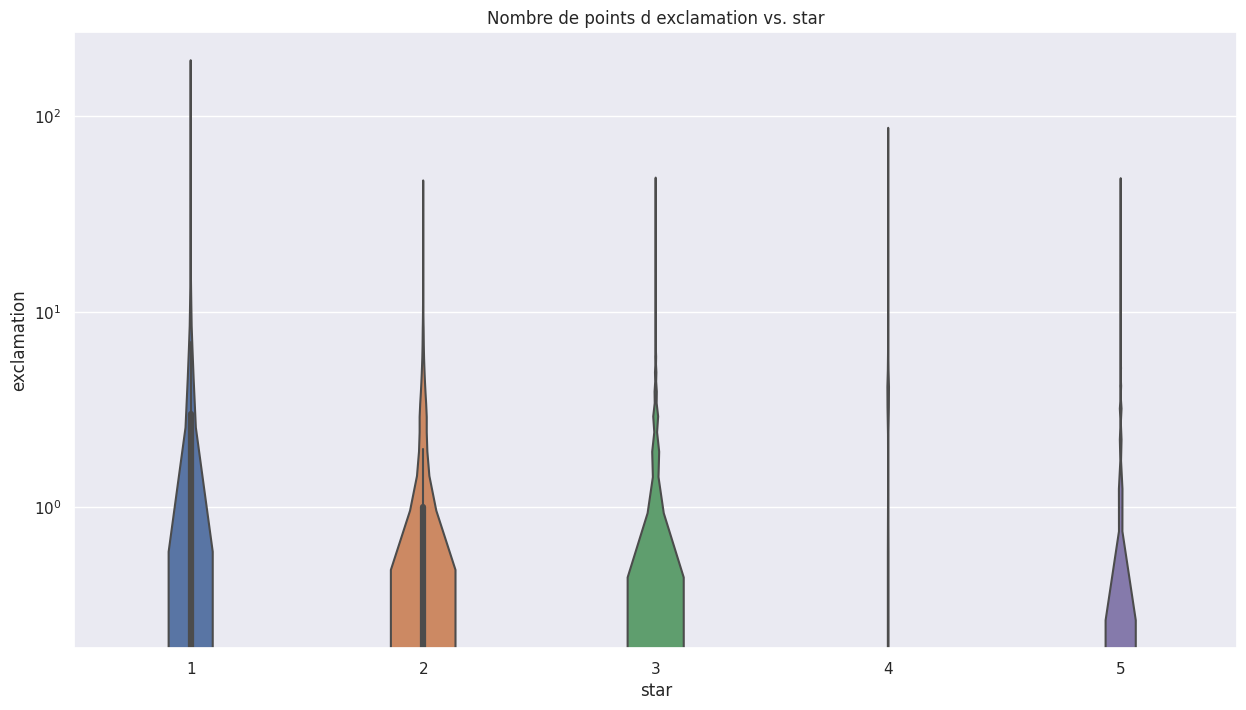

In [15]:
fig, ax = plt.subplots(figsize=[15,8])
sns.violinplot(x="star", y="exclamation", data=df, ax=ax)
plt.yscale('log')
plt.title("Nombre de points d exclamation vs. star")
plt.show()

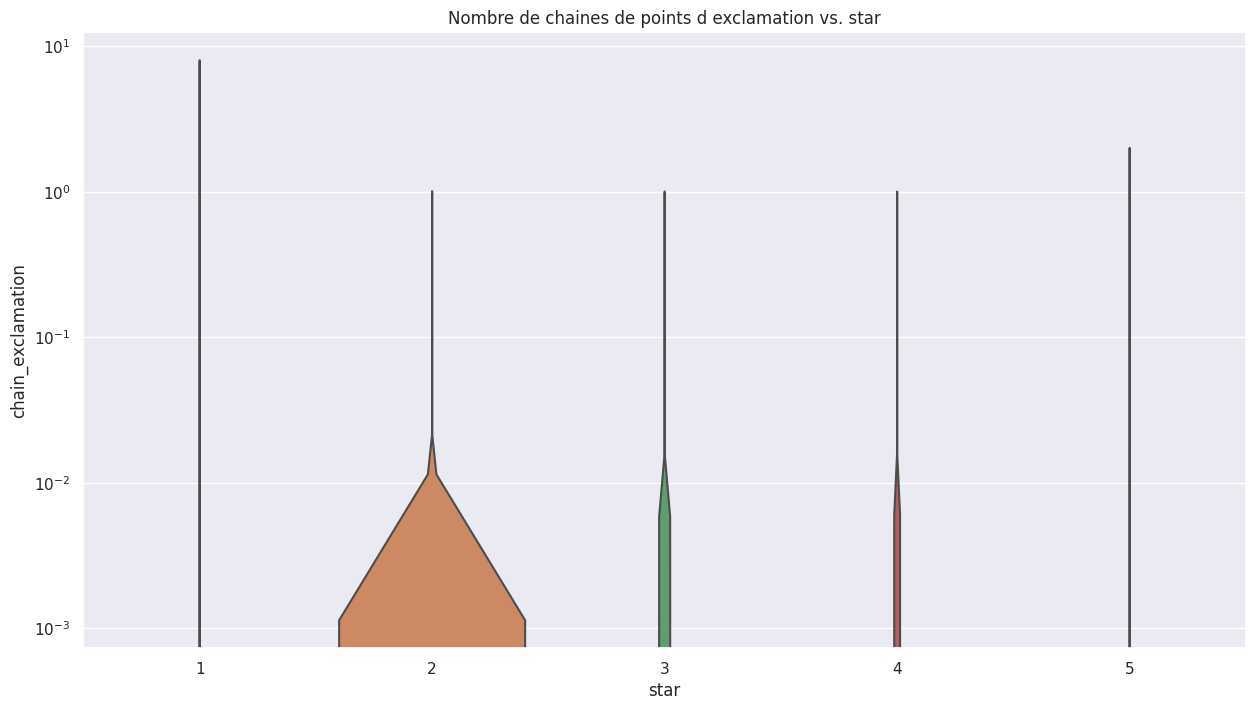

In [16]:
fig, ax = plt.subplots(figsize=[15,8])
sns.violinplot(x="star", y="chain_exclamation", data=df, ax=ax)
plt.yscale('log')
plt.title("Nombre de chaines de points d exclamation vs. star")
plt.show()

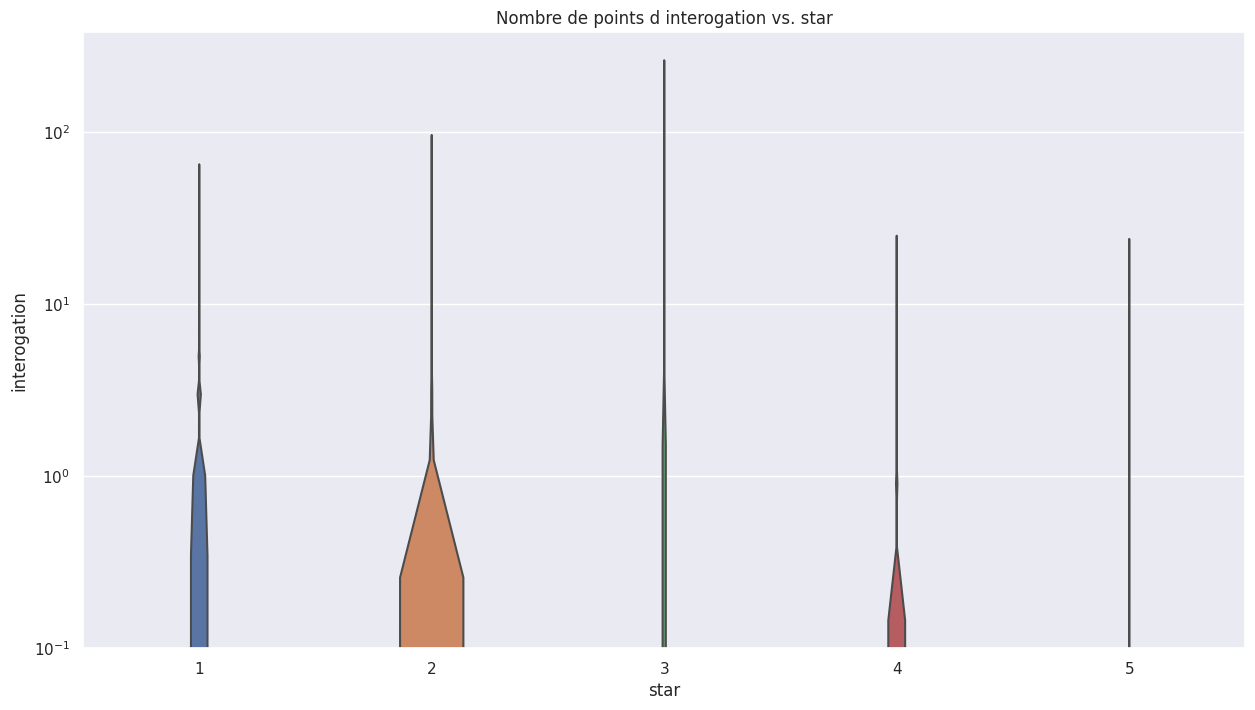

In [17]:
fig, ax = plt.subplots(figsize=[15,8])
sns.violinplot(x="star", y="interogation", data=df, ax=ax)
plt.yscale('log')
plt.title("Nombre de points d interogation vs. star")
plt.show()

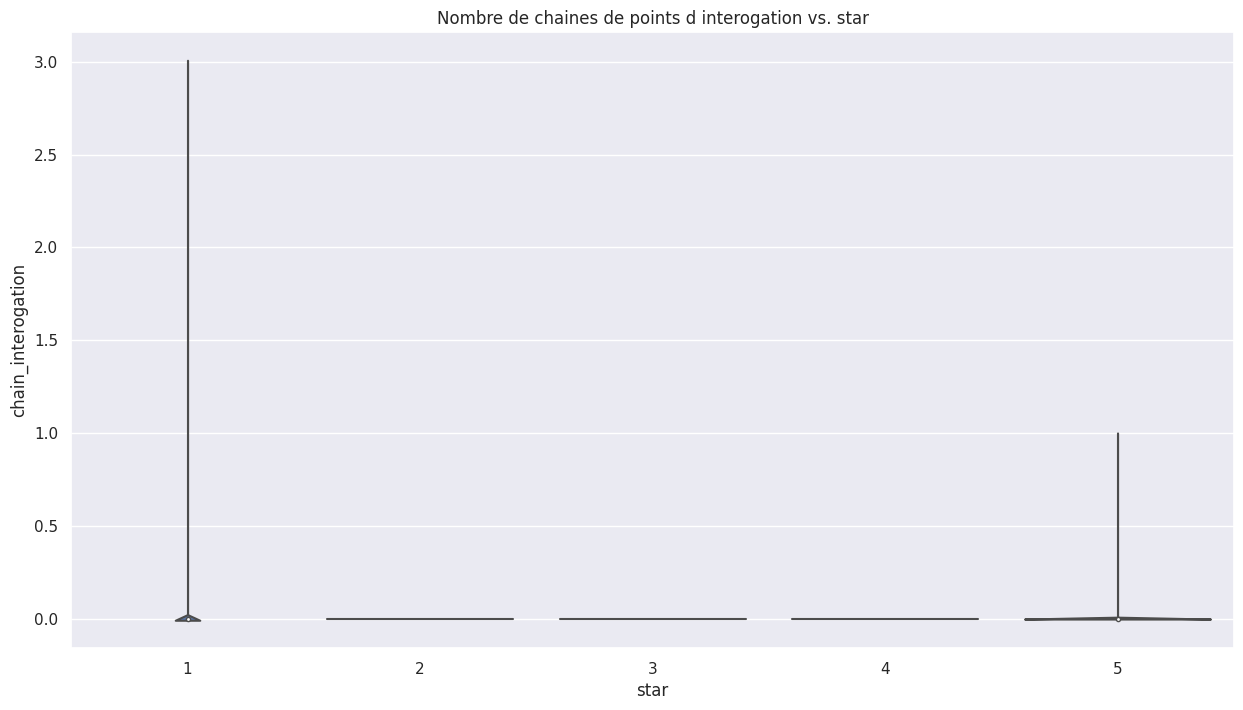

In [18]:
fig, ax = plt.subplots(figsize=[15,8])
sns.violinplot(x="star", y="chain_interogation", data=df, ax=ax)
plt.title("Nombre de chaines de points d interogation vs. star")
plt.show()

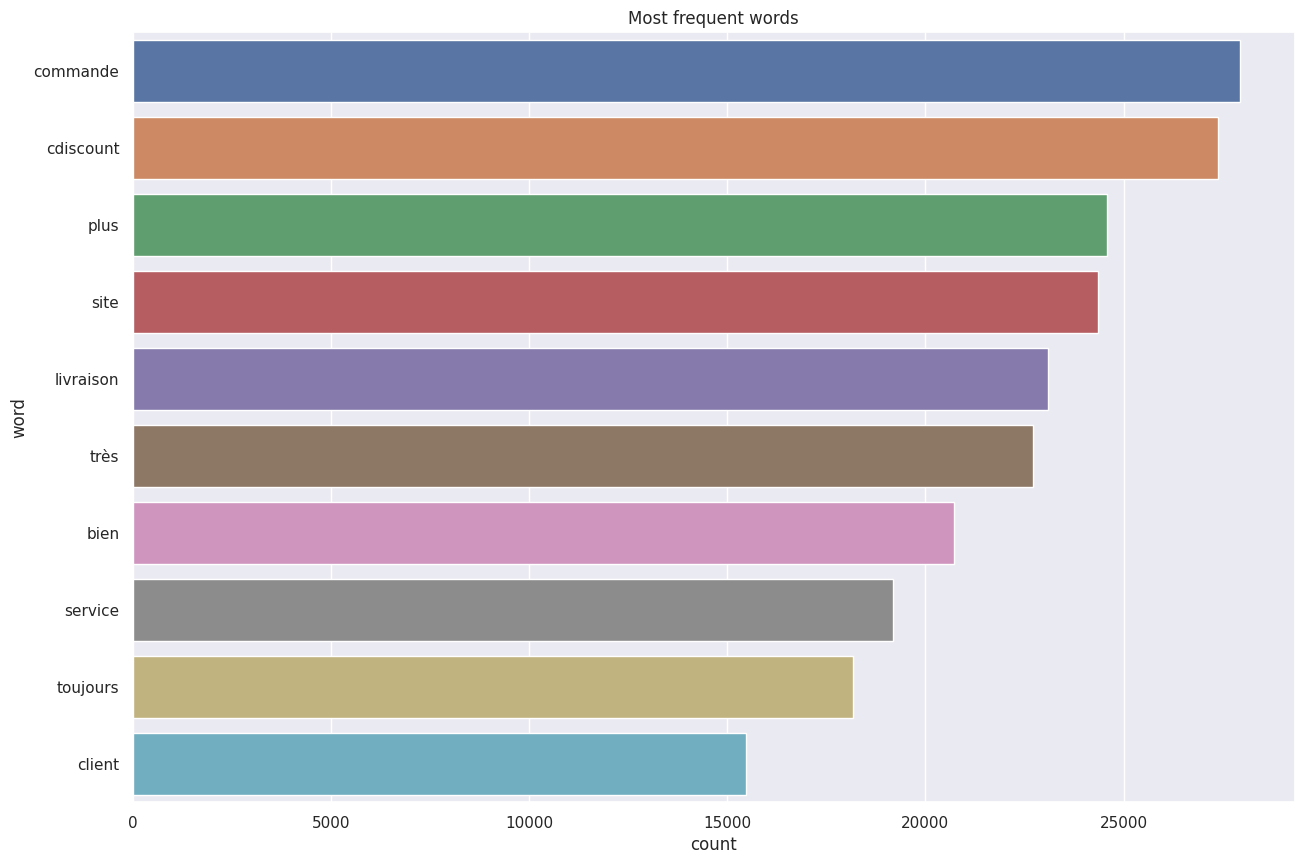

In [28]:
def return_ngram(texts, ngram_range=(1,1)):
    vectorizer = CountVectorizer(stop_words=stopwords.words('french'), ngram_range=ngram_range)
    vectorizer.fit(texts)
    count_list = np.array(vectorizer.transform(texts).sum(0))[0]
    count_words = list(zip(vectorizer.get_feature_names_out(), count_list))
    count_words = sorted(count_words, key=lambda x: x[1], reverse=True)

    count_words = pd.DataFrame(count_words, columns=['word', 'count'])
    return count_words

count_words = return_ngram(df.Commentaire, ngram_range=(1,1))
plt.figure(figsize=(15,10))
sns.barplot(data=count_words.iloc[:10], x='count', y='word')
plt.title("Most frequent words")
plt.show()

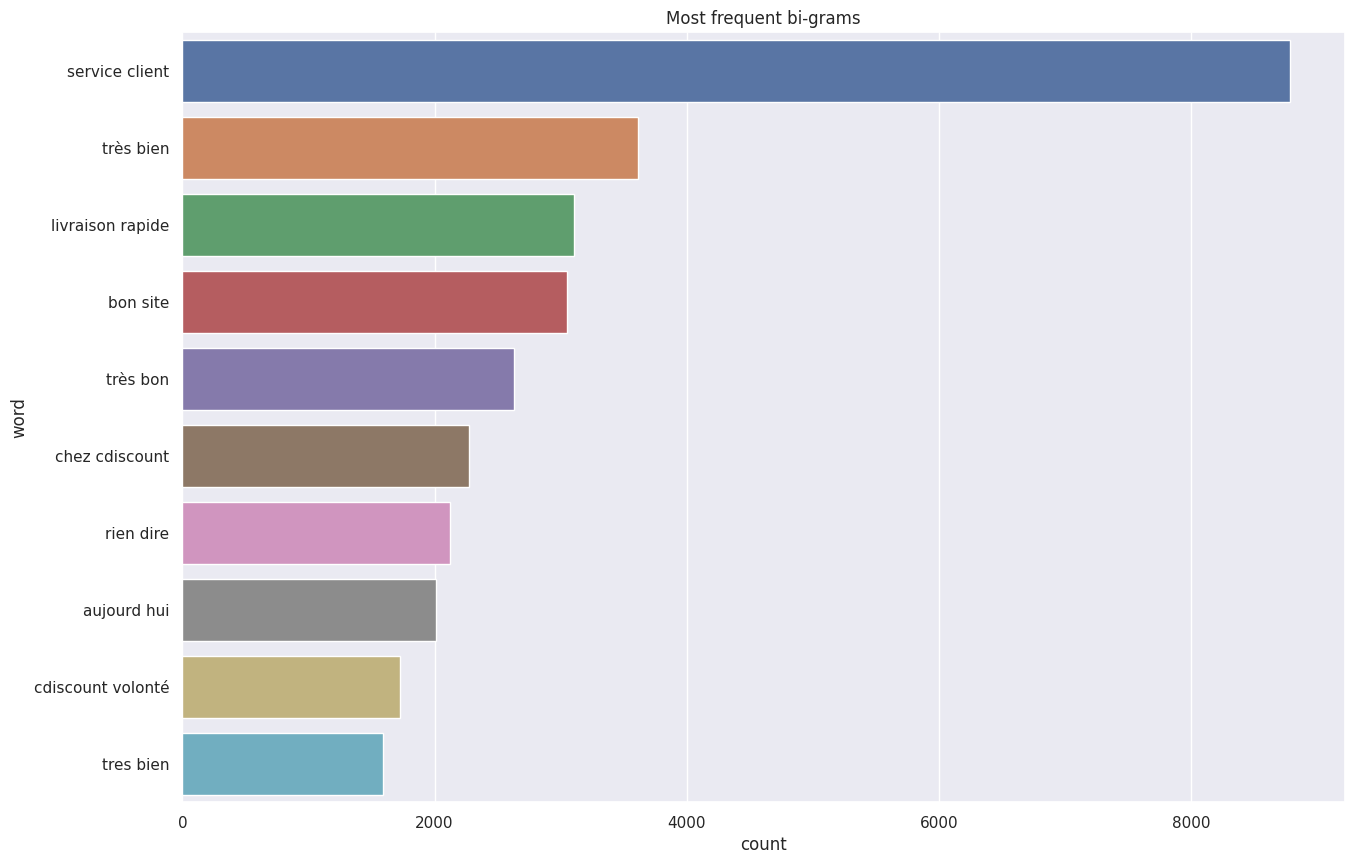

In [29]:
count_words = return_ngram(df.Commentaire, ngram_range=(2,2))
plt.figure(figsize=(15,10))
sns.barplot(data=count_words.iloc[:10], x='count', y='word')
plt.title("Most frequent bi-grams")
plt.show()

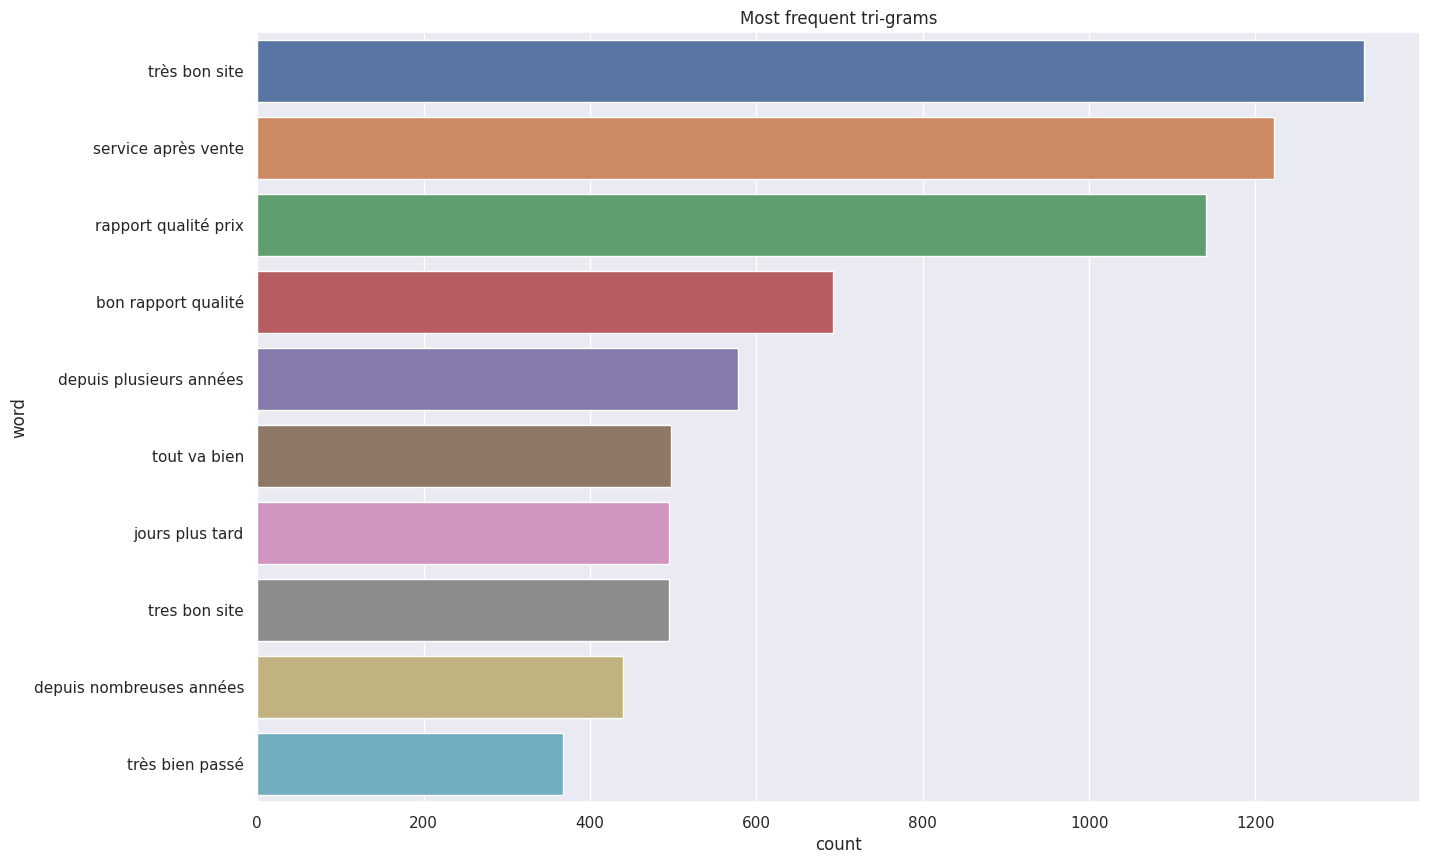

In [30]:
count_words = return_ngram(df.Commentaire, ngram_range=(3,3))
plt.figure(figsize=(15,10))
sns.barplot(data=count_words.iloc[:10], x='count', y='word')
plt.title("Most frequent tri-grams")
plt.show()

In [38]:
def plotNgramsPerStars(df, ngram=1):

    data = df.groupby('star').agg({'Commentaire':lambda x : ' '.join(x), 'star': 'count'})

    vectorizer = TfidfVectorizer( stop_words=stopwords.words('french'), ngram_range=(ngram,ngram))
    vectorizer.fit(df.Commentaire)
    count_list = vectorizer.transform(data.Commentaire).toarray()



    count_words = np.concatenate([np.expand_dims(vectorizer.get_feature_names_out(),1), count_list.T], axis=1)

    count_words = pd.DataFrame(count_words, columns=['word', 'star1', 'star2', 'star3', 'star4', 'star5'])

    count_words[['star1', 'star2', 'star3', 'star4', 'star5']] = count_words[['star1', 'star2', 'star3', 'star4', 'star5']].astype(float)


    plt.figure(figsize=(15,10))
    data_words = count_words.sort_values('star1', ascending=False).head(5)
    plt.subplot(121)
    sns.barplot(data=data_words, x='star1', y='word')
    plt.title('Star 1', fontsize=14)

    data_words = count_words.sort_values('star5', ascending=False).head(5)
    plt.subplot(122)
    sns.barplot(data=data_words, x='star5', y='word')
    plt.title('Star 5', fontsize=14)
    plt.show()

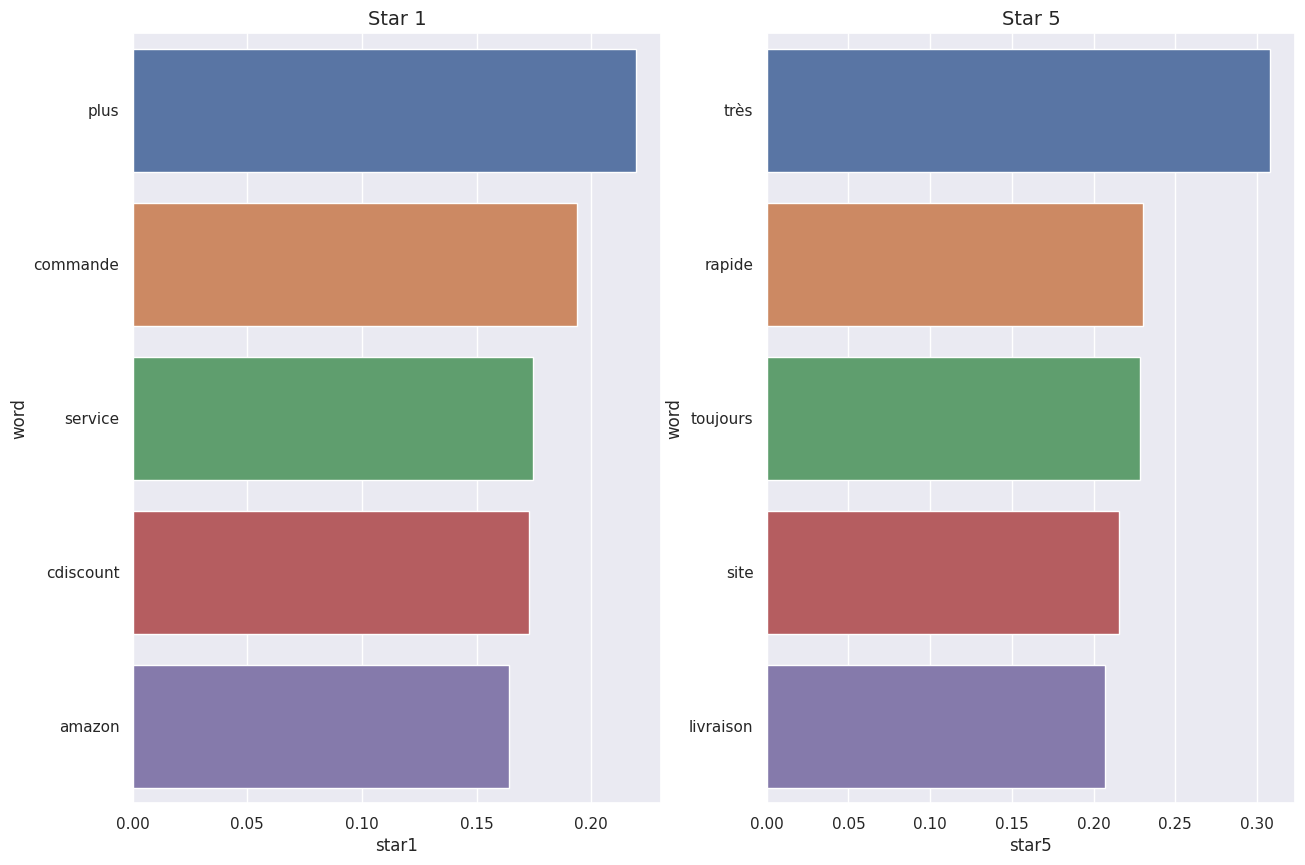

In [39]:
plotNgramsPerStars(df, ngram=1)

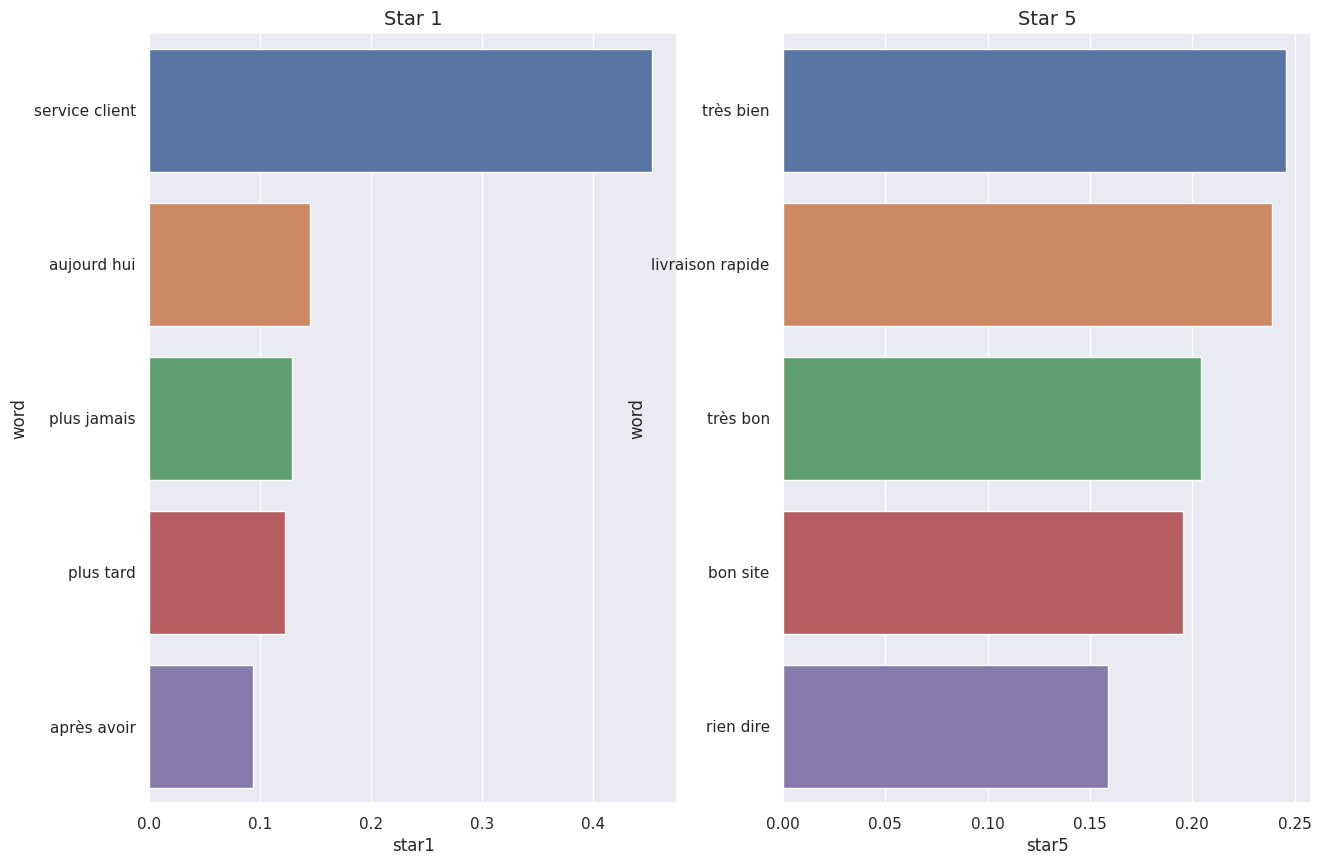

In [40]:
plotNgramsPerStars(df, ngram=2)

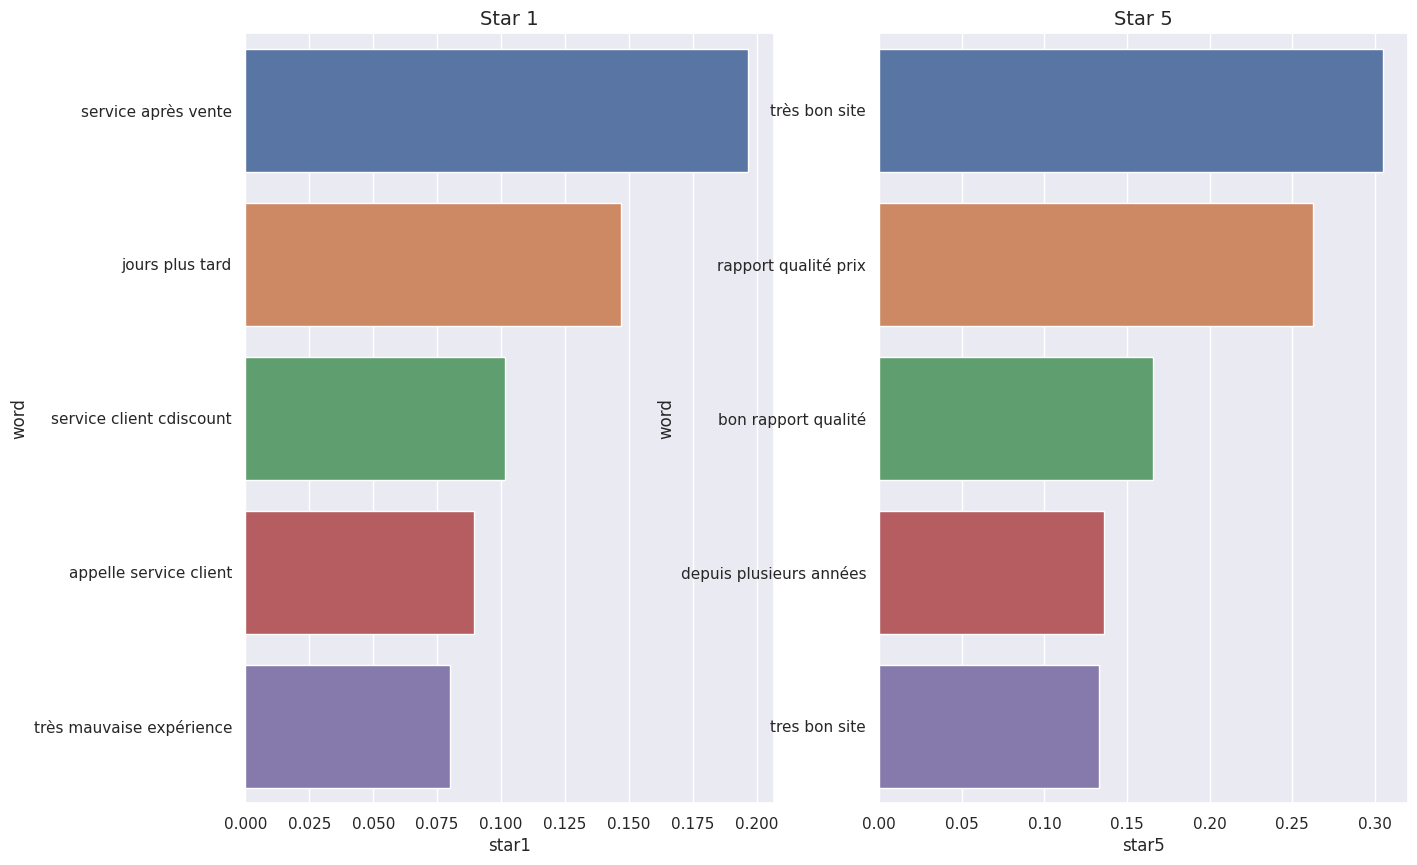

In [41]:
plotNgramsPerStars(df, ngram=3)